In [1]:
import numpy as np
import torch
import mm3dtestdata as mm3d
import fusecam
from fusecam.geometric import space
from fusecam.geometric import embedplane
from fusecam.geometric import interpolate
from fusecam.manipimg import rotate_tensor_cube

from fusecam.aiutil import train_scripts
from fusecam.aiutil import ensembling

import matplotlib.pyplot as plt
import einops

from torch.utils.data import TensorDataset, DataLoader

from dlsia.core.networks import sms3d
from dlsia.core import helpers
from dlsia.viz_tools import draw_sparse_network


import torch.nn as nn
import torch.optim as optim



First we need to build test data, low res and high res.

In [2]:
scale = 100
border = 10
radius = 10

sigma_low = 3.0
sigma_high = .5

In [3]:
obj = mm3d.balls_and_eggs(scale=scale, border=border, radius=radius, k0=1.0)
_, instance_map_0, class_map_0 = obj.fill()

/tmp/ipykernel_24430/3811926222.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('Set1', 3)


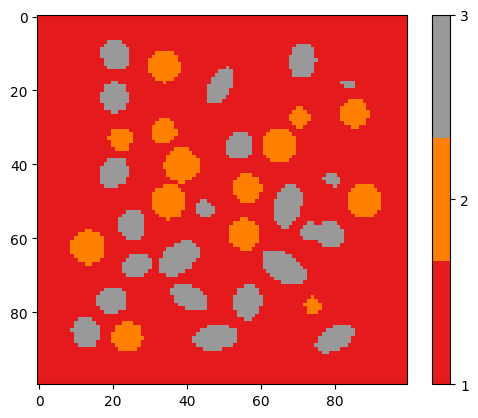

In [4]:
cmap = plt.cm.get_cmap('Set1', 3)
plt.imshow(class_map_0[32,...], cmap=cmap, interpolation='none')
cbar = plt.colorbar(ticks=[0,1,2,3] )#np.arange(np.min(0), np.max(3) + 1))
plt.show()

In [5]:
class_map_low = mm3d.blur_it(class_map_0, sigma=sigma_low)
class_map_high = mm3d.blur_it(class_map_0, sigma=sigma_high)

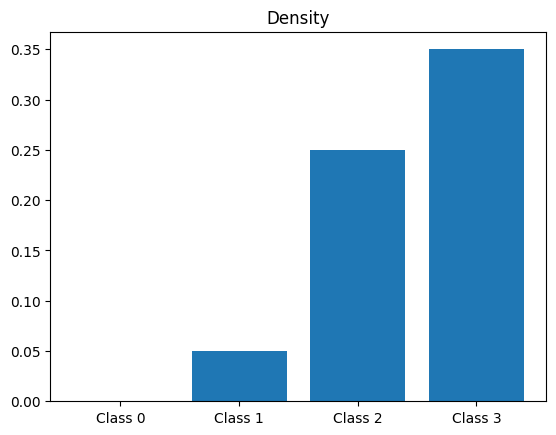

In [6]:
tomo_class_0 = np.array([0])
tomo_class_1 = np.array([0.05])
tomo_class_2 = np.array([0.25])
tomo_class_3 = np.array([0.35])
class_actions_tomo = np.column_stack([tomo_class_0,
                                      tomo_class_1,
                                      tomo_class_2,
                                      tomo_class_3]).T

plt.bar( ["Class 0", "Class 1", "Class 2", "Class 3"],class_actions_tomo.ravel() )
plt.title("Density")
plt.show()

In [9]:
low_map = mm3d.compute_weighted_map(class_map_low, class_actions_tomo)
high_map = mm3d.compute_weighted_map(class_map_high, class_actions_tomo)

low_map = low_map + mm3d.noise(low_map, 0.01, 0.0)
high_map = high_map + mm3d.noise(high_map, 0.21, 0.0)

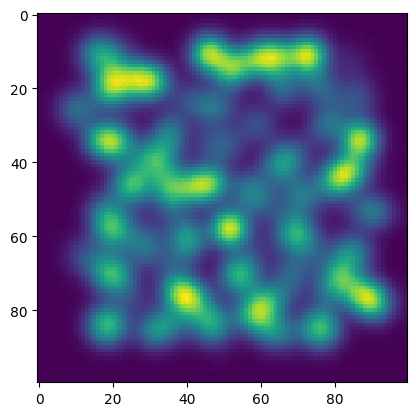

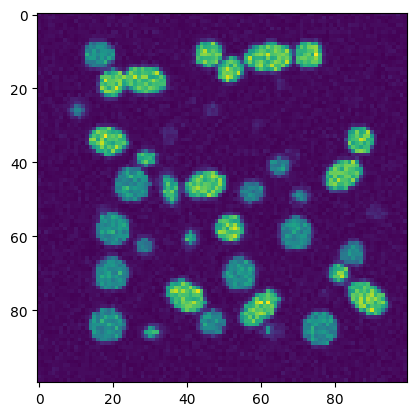

In [10]:
plt.imshow(low_map[0, :,:,scale//2])
plt.show()

plt.imshow(high_map[0, :,:,scale//2])
plt.show()

Now that we have data, I will use have to make the geometric objects

In [11]:
space_object = space.SpatialVolumeMetric(origin=(0,0,0),
                                         step_size=(1,1,1),
                                         orientation = torch.eye(3),
                                         translation = (0,0,0),
                                        )
plane_object = space.SpatialPlaneMetric(origin=(0,0),
                                         step_size=(1,1),
                                         orientation = torch.eye(2),
                                         translation = (0,0))

Now we have the two geometric objects, I want define a plane and get stuff going

In [12]:
u = torch.linspace(0,scale-1,scale)
U,V = torch.meshgrid(u,u, indexing='ij')
UV = torch.concat([U.flatten().reshape(1,-1), V.flatten().reshape(1,-1)]).T

x = torch.linspace(0,scale-1,scale)
X,Y,Z = torch.meshgrid(x,x,x, indexing="ij")
XYZ = torch.concat([X.flatten().reshape(1,-1), Y.flatten().reshape(1,-1), Z.flatten().reshape(1,-1),]).T 
print(UV.shape, XYZ.shape)

torch.Size([10000, 2]) torch.Size([1000000, 3])


In [13]:
aligner_1 = embedplane.Plane3DAligner(
    normal=[0.0, 0.1, 1.0], 
    point_on_plane=[scale//2, scale//2, scale//2]
)
point_on_plane_2D_1 = (scale//2,scale//2)
aligned_points_1 = aligner_1.align_points_to_3d(UV, point_on_plane_2D_1, rotation_angle=0)

aligner_2 = embedplane.Plane3DAligner(
    normal=[0.0, 0.1, 1.0], 
    point_on_plane=[scale//2, scale//2, scale//3]
)
point_on_plane_2D_2 = (scale//2,scale//2)
aligned_points_2 = aligner_2.align_points_to_3d(UV, point_on_plane_2D_2, rotation_angle=0)

aligner_3 = embedplane.Plane3DAligner(
    normal=[0.0, 0.1, 1.0], 
    point_on_plane=[scale//2, scale//2, scale//4]
)
point_on_plane_2D_3 = (scale//2,scale//2)
aligned_points_3 = aligner_3.align_points_to_3d(UV, point_on_plane_2D_3, rotation_angle=0)



In [14]:
indices_1, near_dist_1 = interpolate.find_nearest(XYZ, aligned_points_1, 5)
weights_1 = interpolate.compute_weights(near_dist_1, power=3.0, cutoff=2.0)

indices_2, near_dist_2 = interpolate.find_nearest(XYZ, aligned_points_2, 5)
weights_2 = interpolate.compute_weights(near_dist_2, power=3.0, cutoff=2.0)

indices_3, near_dist_3 = interpolate.find_nearest(XYZ, aligned_points_3, 5)
weights_3 = interpolate.compute_weights(near_dist_3, power=3.0, cutoff=2.0)


In [15]:
gt_1 = interpolate.inverse_distance_weighting_with_weights(torch.Tensor(high_map.flatten()), 
                                                                         indices_1, 
                                                                         weights_1)
gt_2 = interpolate.inverse_distance_weighting_with_weights(torch.Tensor(high_map.flatten()), 
                                                                         indices_2, 
                                                                         weights_2)
gt_3 = interpolate.inverse_distance_weighting_with_weights(torch.Tensor(high_map.flatten()), 
                                                                         indices_3, 
                                                                         weights_3)


In [16]:
funct_1= einops.rearrange(funct_1, "(X Y) -> X Y ",X=scale, Y=scale)
plt.imshow(funct_1.numpy() )
plt.colorbar()
plt.show()

plt.imshow(high_map[0, :,:,scale//2])
plt.colorbar()
plt.show()

funct_2 = einops.rearrange(funct_2, "(X Y) -> X Y",X=scale, Y=scale)
plt.imshow(funct_2.numpy() )
plt.colorbar()
plt.show()


plt.imshow( high_map[0, :,:,scale//3]) 
plt.colorbar()
plt.show()

funct_3 = einops.rearrange(funct_3, "(X Y) -> X Y",X=scale, Y=scale)
plt.imshow(funct_3.numpy() )
plt.colorbar()
plt.show()


plt.imshow( high_map[0, :,:,scale//4]) 
plt.colorbar()
plt.show()




NameError: name 'funct_1' is not defined

In [ ]:
plt.imshow(funct_1.numpy() - high_map[0, :,:,scale//2])
plt.colorbar()
plt.show()

plt.imshow(funct_2.numpy() - high_map[0, :,:,scale//3])
plt.colorbar()
plt.show()


Build Data Loader

In [17]:
my_3d_maps = torch.concat([torch.Tensor(low_map).unsqueeze(0),
                          ])

#my_2d_maps = torch.concat([torch.Tensor(high_map[0, :,:,scale//2]).flatten(),
#                           torch.Tensor(high_map[0, :,:,scale//3]).flatten(),
#                           torch.Tensor(high_map[0, :,:,scale//4]).flatten(),
#                          ]).unsqueeze(0)

my_2d_maps = torch.concat([gt_1.flatten(),
                           gt_2.flatten(),
                           gt_3.flatten(),
                          ]).unsqueeze(0)

my_weights = torch.concat([weights_1, weights_2,  weights_3]).unsqueeze(0)

my_indices = torch.concat([indices_1, indices_2, indices_3]).unsqueeze(0)
                           

In [18]:
my_data = TensorDataset(my_3d_maps, my_2d_maps, my_weights, my_indices)                          
data_loader = DataLoader(my_data, batch_size=1) 

In [32]:
n_networks = 11
networks = ensembling.construct_3dsms_ensembler(n_networks=n_networks,
                                                in_channels=1,
                                                out_channels=1,
                                                layers = 10,
                                                alpha=0.00,
                                                gamma=0.00,
                                                hidden_channels=[10],
                                                parameter_bounds=[50000,60000],
                                                network_type="Regression"
                                               )

55433
51663
52063
57273
51933
54083
52393


/storage/Projects/dlsia_dev/dlsia/dlsia/viz_tools/draw_sparse_network.py:187: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  chan_fig = plt.figure(figsize=(fsize + 1, fsize + 1))


52283
56233
50003
59993


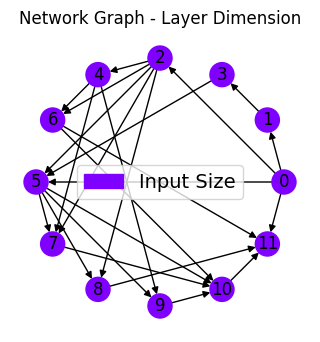

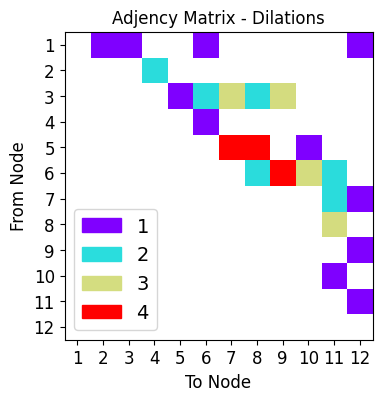

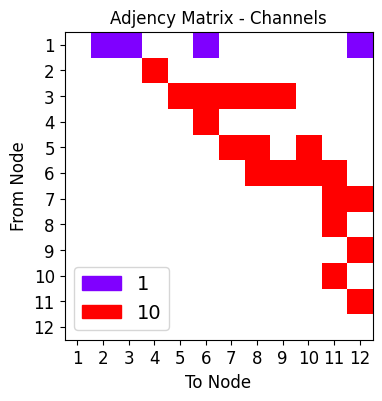

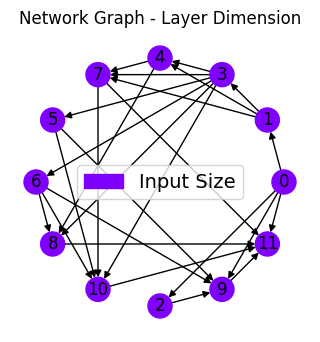

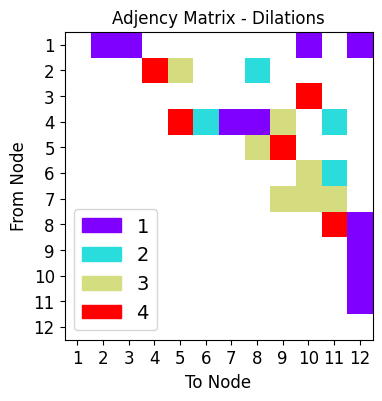

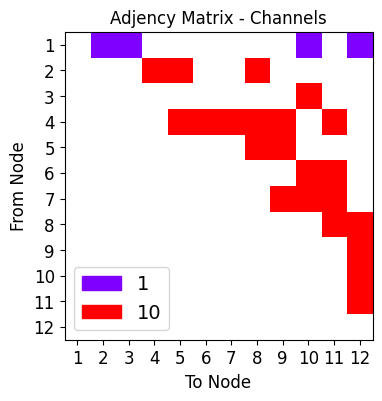

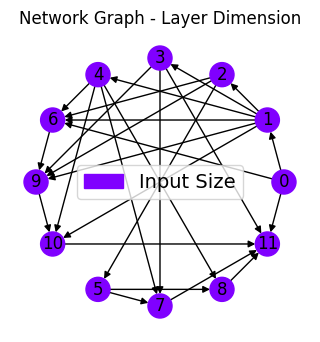

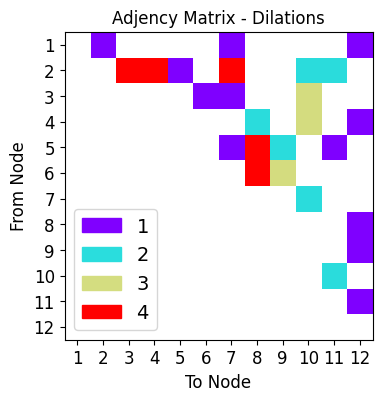

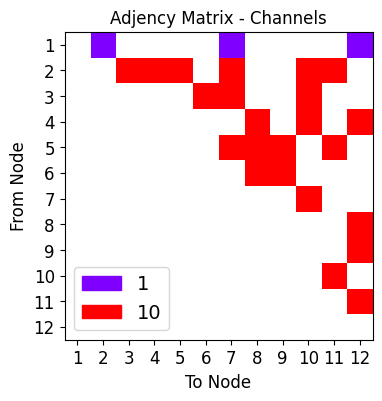

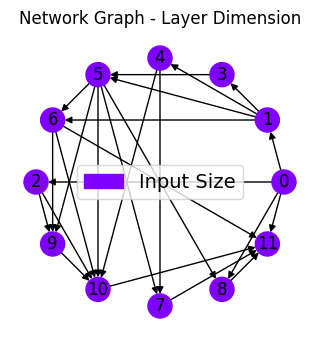

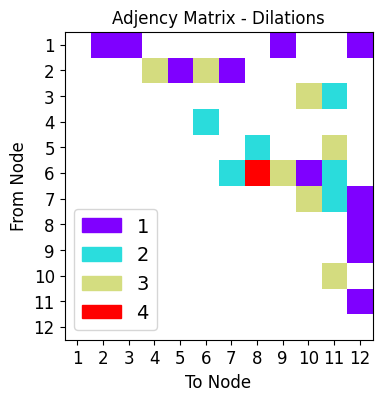

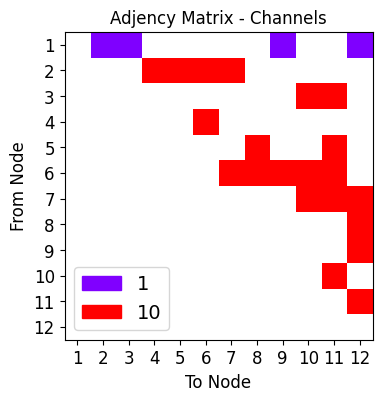

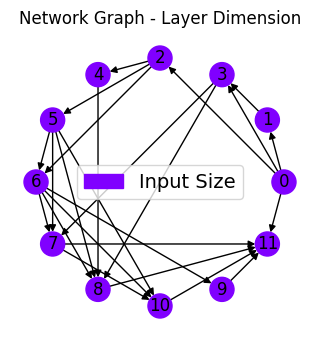

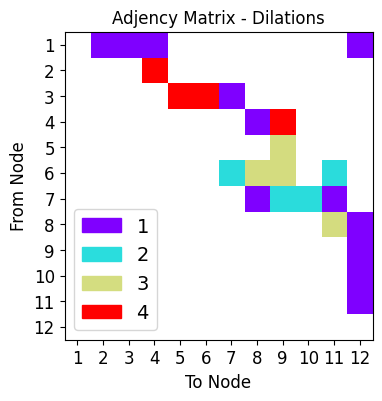

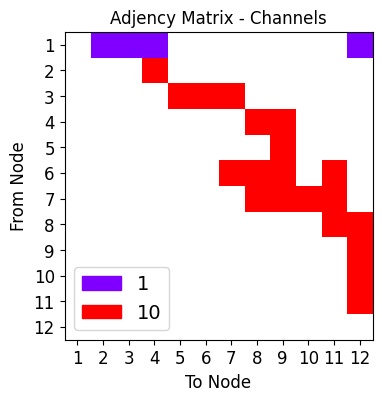

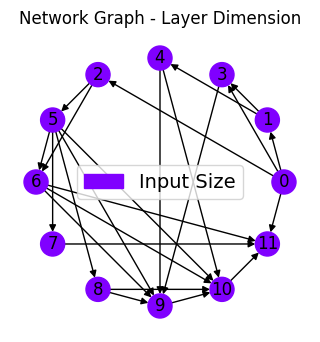

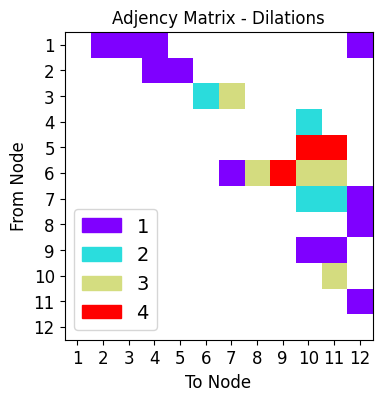

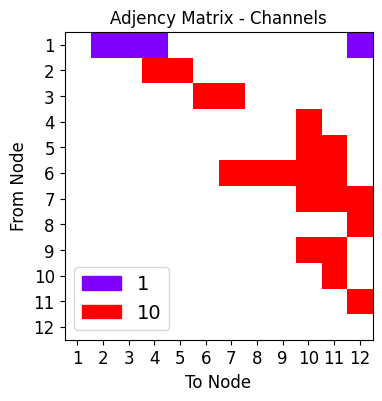

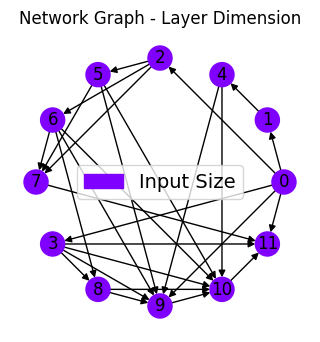

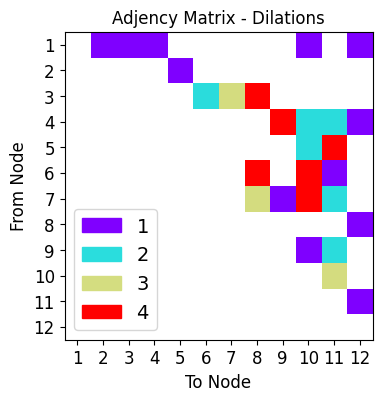

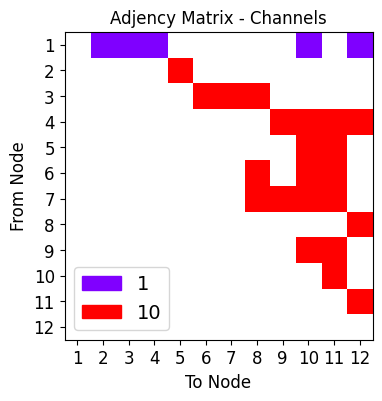

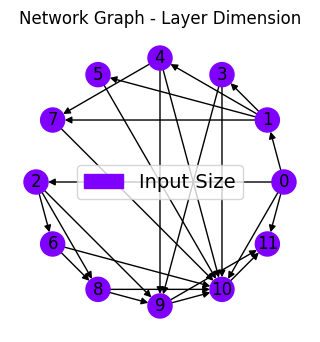

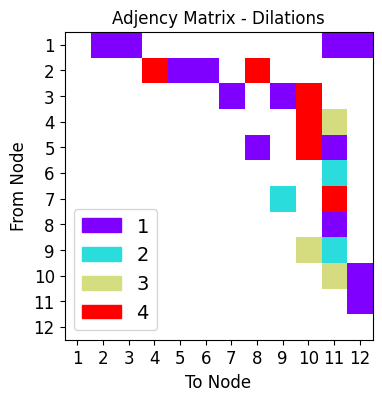

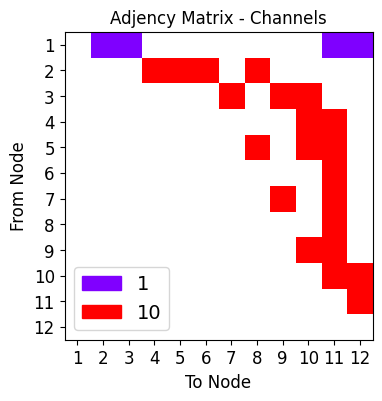

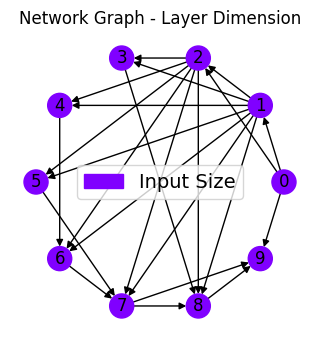

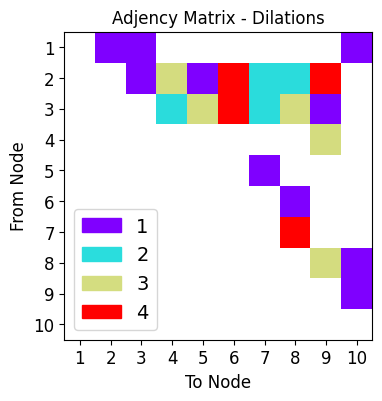

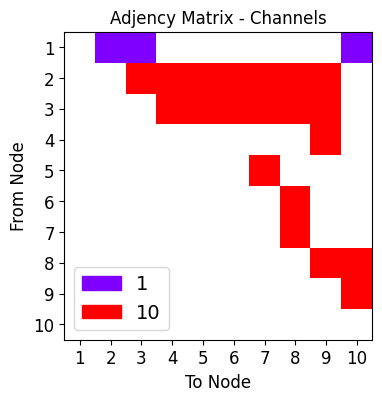

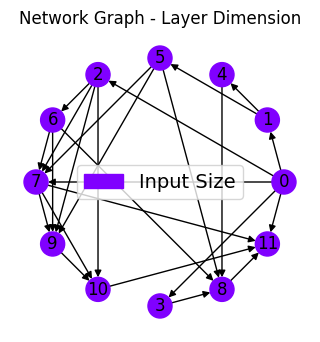

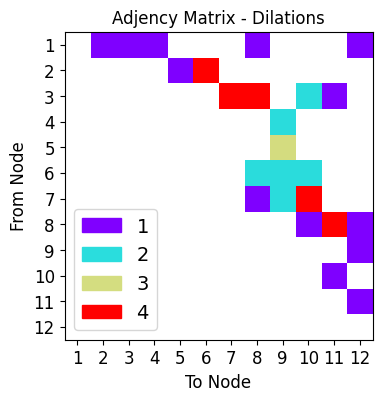

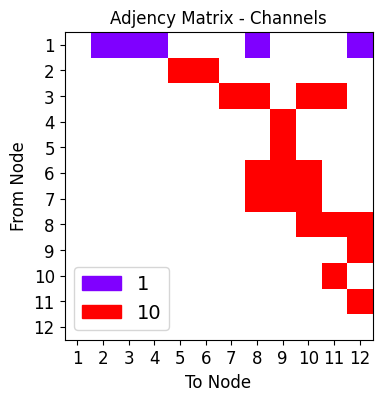

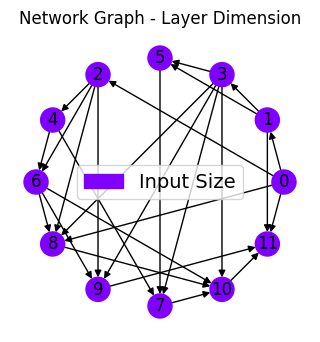

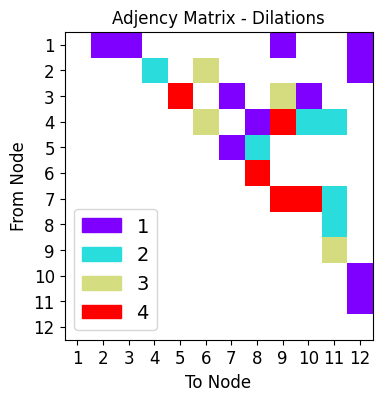

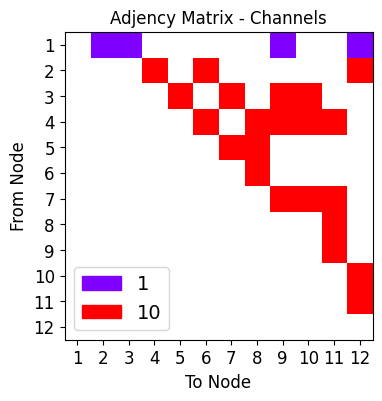

In [33]:
for net in networks:
    print( helpers.count_parameters(net) )
    a,b,c = draw_sparse_network.draw_network(net)
    
    

In [39]:
for net in networks:
    loss_function = nn.MSELoss()
    optimizer = optim.Adam(net.parameters(), lr=0.001)
    train_scripts.train_volume_on_slice(net, 
            loss_function, 
            optimizer, 
            data_loader, 
            500, 
            interpolate.inverse_distance_weighting_with_weights, device='cuda:0')
    print()
    print()
    
    

Epoch [1/500], Loss: 0.0006229276768863201
Epoch [2/500], Loss: 0.005257392302155495
Epoch [3/500], Loss: 0.0008654715493321419
Epoch [4/500], Loss: 0.0014966059243306518
Epoch [5/500], Loss: 0.0025474487338215113
Epoch [6/500], Loss: 0.0023327888920903206
Epoch [7/500], Loss: 0.0016940048662945628
Epoch [8/500], Loss: 0.0013151885941624641
Epoch [9/500], Loss: 0.0012948558432981372
Epoch [10/500], Loss: 0.001370424055494368
Epoch [11/500], Loss: 0.0013328219065442681
Epoch [12/500], Loss: 0.001201711012981832
Epoch [13/500], Loss: 0.0010820131283253431
Epoch [14/500], Loss: 0.0010252428473904729
Epoch [15/500], Loss: 0.0010121705709025264
Epoch [16/500], Loss: 0.001005512080155313
Epoch [17/500], Loss: 0.0009943260811269283
Epoch [18/500], Loss: 0.0009756539948284626
Epoch [19/500], Loss: 0.0009499697480350733
Epoch [20/500], Loss: 0.0009266174165531993
Epoch [21/500], Loss: 0.0009053876856341958
Epoch [22/500], Loss: 0.000880849955137819
Epoch [23/500], Loss: 0.0008493523928336799
Ep

Epoch [187/500], Loss: 0.0005281405756250024
Epoch [188/500], Loss: 0.0005274411523714662
Epoch [189/500], Loss: 0.0005267437663860619
Epoch [190/500], Loss: 0.000526045507285744
Epoch [191/500], Loss: 0.00052533985581249
Epoch [192/500], Loss: 0.0005246584769338369
Epoch [193/500], Loss: 0.0005239792517386377
Epoch [194/500], Loss: 0.0005233013071119785
Epoch [195/500], Loss: 0.000522604095749557
Epoch [196/500], Loss: 0.0005219231243245304
Epoch [197/500], Loss: 0.0005212306277826428
Epoch [198/500], Loss: 0.0005205283523537219
Epoch [199/500], Loss: 0.0005198545986786485
Epoch [200/500], Loss: 0.0005191747331991792
Epoch [201/500], Loss: 0.0005184789770282805
Epoch [202/500], Loss: 0.0005177785060368478
Epoch [203/500], Loss: 0.0005170854274183512
Epoch [204/500], Loss: 0.0005164033500477672
Epoch [205/500], Loss: 0.0005157100385986269
Epoch [206/500], Loss: 0.0005150101496838033
Epoch [207/500], Loss: 0.0005143191083334386
Epoch [208/500], Loss: 0.0005136122927069664
Epoch [209/500

Epoch [369/500], Loss: 0.0003846883773803711
Epoch [370/500], Loss: 0.00038319805753417313
Epoch [371/500], Loss: 0.0003836046962533146
Epoch [372/500], Loss: 0.0003846288600470871
Epoch [373/500], Loss: 0.0003843336889985949
Epoch [374/500], Loss: 0.0003835272218566388
Epoch [375/500], Loss: 0.0003817623946815729
Epoch [376/500], Loss: 0.0003830794885288924
Epoch [377/500], Loss: 0.00038624758599326015
Epoch [378/500], Loss: 0.0003854875103570521
Epoch [379/500], Loss: 0.0003864451718982309
Epoch [380/500], Loss: 0.000393647700548172
Epoch [381/500], Loss: 0.00039581902092322707
Epoch [382/500], Loss: 0.0003971392288804054
Epoch [383/500], Loss: 0.0003913379623554647
Epoch [384/500], Loss: 0.00038097580545581877
Epoch [385/500], Loss: 0.0003735210339073092
Epoch [386/500], Loss: 0.0003787994501180947
Epoch [387/500], Loss: 0.00038480700459331274
Epoch [388/500], Loss: 0.0003834326344076544
Epoch [389/500], Loss: 0.00038018880877643824
Epoch [390/500], Loss: 0.0003733292396645993
Epoch

Epoch [53/500], Loss: 0.00128771155141294
Epoch [54/500], Loss: 0.0012852033833041787
Epoch [55/500], Loss: 0.0012793433852493763
Epoch [56/500], Loss: 0.0012752660550177097
Epoch [57/500], Loss: 0.001274777576327324
Epoch [58/500], Loss: 0.0012752660550177097
Epoch [59/500], Loss: 0.001273410045541823
Epoch [60/500], Loss: 0.0012694832403212786
Epoch [61/500], Loss: 0.0012660807697102427
Epoch [62/500], Loss: 0.0012651719152927399
Epoch [63/500], Loss: 0.0012650788994506001
Epoch [64/500], Loss: 0.0012633154401555657
Epoch [65/500], Loss: 0.0012601279886439443
Epoch [66/500], Loss: 0.001257798750884831
Epoch [67/500], Loss: 0.0012568547390401363
Epoch [68/500], Loss: 0.0012558408780023456
Epoch [69/500], Loss: 0.0012538288719952106
Epoch [70/500], Loss: 0.0012516428250819445
Epoch [71/500], Loss: 0.0012499191798269749
Epoch [72/500], Loss: 0.0012487864587455988
Epoch [73/500], Loss: 0.0012473419774323702
Epoch [74/500], Loss: 0.0012452407972887158
Epoch [75/500], Loss: 0.0012434397358

Epoch [237/500], Loss: 0.0009048169595189393
Epoch [238/500], Loss: 0.0009037208510562778
Epoch [239/500], Loss: 0.000893329968675971
Epoch [240/500], Loss: 0.0008936198428273201
Epoch [241/500], Loss: 0.0009015079704113305
Epoch [242/500], Loss: 0.0008921297849155962
Epoch [243/500], Loss: 0.0008858875371515751
Epoch [244/500], Loss: 0.0008816743502393365
Epoch [245/500], Loss: 0.0008840469527058303
Epoch [246/500], Loss: 0.0008889437303878367
Epoch [247/500], Loss: 0.0008805774850770831
Epoch [248/500], Loss: 0.0008721726480871439
Epoch [249/500], Loss: 0.0008713979623280466
Epoch [250/500], Loss: 0.0008736614254303277
Epoch [251/500], Loss: 0.0008773401496000588
Epoch [252/500], Loss: 0.0008680404280312359
Epoch [253/500], Loss: 0.0008602960151620209
Epoch [254/500], Loss: 0.0008599756984040141
Epoch [255/500], Loss: 0.0008613958489149809
Epoch [256/500], Loss: 0.0008640548912808299
Epoch [257/500], Loss: 0.0008564282325096428
Epoch [258/500], Loss: 0.0008489190367981791
Epoch [259/

Epoch [421/500], Loss: 0.0005809651920571923
Epoch [422/500], Loss: 0.0005826269625686109
Epoch [423/500], Loss: 0.0005830345908179879
Epoch [424/500], Loss: 0.0005810724687762558
Epoch [425/500], Loss: 0.0005732926074415445
Epoch [426/500], Loss: 0.0005618897848762572
Epoch [427/500], Loss: 0.0005557781551033258
Epoch [428/500], Loss: 0.0005568127380684018
Epoch [429/500], Loss: 0.0005623308825306594
Epoch [430/500], Loss: 0.0005725502269342542
Epoch [431/500], Loss: 0.0005822815001010895
Epoch [432/500], Loss: 0.0005926336743868887
Epoch [433/500], Loss: 0.0005966738099232316
Epoch [434/500], Loss: 0.000584365101531148
Epoch [435/500], Loss: 0.0005590800428763032
Epoch [436/500], Loss: 0.00055111781693995
Epoch [437/500], Loss: 0.0005643708864226937
Epoch [438/500], Loss: 0.000575501995626837
Epoch [439/500], Loss: 0.0005715508013963699
Epoch [440/500], Loss: 0.0005550974747166038
Epoch [441/500], Loss: 0.0005417831125669181
Epoch [442/500], Loss: 0.0005437692161649466
Epoch [443/500

Epoch [107/500], Loss: 0.0006604100344702601
Epoch [108/500], Loss: 0.0006592943682335317
Epoch [109/500], Loss: 0.0006581328343600035
Epoch [110/500], Loss: 0.0006570215919055045
Epoch [111/500], Loss: 0.0006559206522069871
Epoch [112/500], Loss: 0.000654790666885674
Epoch [113/500], Loss: 0.0006536261062137783
Epoch [114/500], Loss: 0.0006525302887894213
Epoch [115/500], Loss: 0.000651351292617619
Epoch [116/500], Loss: 0.0006502239848487079
Epoch [117/500], Loss: 0.000649066234473139
Epoch [118/500], Loss: 0.0006479098228737712
Epoch [119/500], Loss: 0.0006467882776632905
Epoch [120/500], Loss: 0.000645643041934818
Epoch [121/500], Loss: 0.0006445038598030806
Epoch [122/500], Loss: 0.000643365376163274
Epoch [123/500], Loss: 0.0006422260776162148
Epoch [124/500], Loss: 0.0006410490605048835
Epoch [125/500], Loss: 0.0006399017293006182
Epoch [126/500], Loss: 0.0006387158064171672
Epoch [127/500], Loss: 0.0006375089287757874
Epoch [128/500], Loss: 0.000636329990811646
Epoch [129/500],

Epoch [289/500], Loss: 0.00041684729512780905
Epoch [290/500], Loss: 0.00041300259181298316
Epoch [291/500], Loss: 0.00040864787297323346
Epoch [292/500], Loss: 0.0004070654103998095
Epoch [293/500], Loss: 0.00040680376696400344
Epoch [294/500], Loss: 0.000405407277867198
Epoch [295/500], Loss: 0.0004043499066028744
Epoch [296/500], Loss: 0.0004046221438329667
Epoch [297/500], Loss: 0.0004056532634422183
Epoch [298/500], Loss: 0.00040796276880428195
Epoch [299/500], Loss: 0.00041120455716736615
Epoch [300/500], Loss: 0.0004140506498515606
Epoch [301/500], Loss: 0.00041019852505996823
Epoch [302/500], Loss: 0.0004055335302837193
Epoch [303/500], Loss: 0.0003966009244322777
Epoch [304/500], Loss: 0.00039302807999774814
Epoch [305/500], Loss: 0.00039523583836853504
Epoch [306/500], Loss: 0.0004000263870693743
Epoch [307/500], Loss: 0.0004033589211758226
Epoch [308/500], Loss: 0.0003978392342105508
Epoch [309/500], Loss: 0.00039190781535580754
Epoch [310/500], Loss: 0.0003864297177642584
E

Epoch [471/500], Loss: 0.0002735349989961833
Epoch [472/500], Loss: 0.0002769847051240504
Epoch [473/500], Loss: 0.0002818205684889108
Epoch [474/500], Loss: 0.00028806147747673094
Epoch [475/500], Loss: 0.00028866928187198937
Epoch [476/500], Loss: 0.0002879241365008056
Epoch [477/500], Loss: 0.00027940698782913387
Epoch [478/500], Loss: 0.00027091256924904883
Epoch [479/500], Loss: 0.00026766155497170985
Epoch [480/500], Loss: 0.0002719777694437653
Epoch [481/500], Loss: 0.00028268719324842095
Epoch [482/500], Loss: 0.0002818389912135899
Epoch [483/500], Loss: 0.000278837134828791
Epoch [484/500], Loss: 0.00026700252783484757
Epoch [485/500], Loss: 0.0002601515734568238
Epoch [486/500], Loss: 0.00026132355560548604
Epoch [487/500], Loss: 0.00026602495927363634
Epoch [488/500], Loss: 0.00027059679268859327
Epoch [489/500], Loss: 0.00026886051637120545
Epoch [490/500], Loss: 0.00026683349278755486
Epoch [491/500], Loss: 0.0002621333987917751
Epoch [492/500], Loss: 0.0002624436456244439

Epoch [157/500], Loss: 0.0005266116932034492
Epoch [158/500], Loss: 0.0005258030723780394
Epoch [159/500], Loss: 0.0005249891546554863
Epoch [160/500], Loss: 0.0005242078914307058
Epoch [161/500], Loss: 0.0005233740666881204
Epoch [162/500], Loss: 0.0005225915228947997
Epoch [163/500], Loss: 0.000521754496730864
Epoch [164/500], Loss: 0.0005209174705669284
Epoch [165/500], Loss: 0.0005201011663302779
Epoch [166/500], Loss: 0.0005192984244786203
Epoch [167/500], Loss: 0.0005184701294638216
Epoch [168/500], Loss: 0.0005176576087251306
Epoch [169/500], Loss: 0.0005168577772565186
Epoch [170/500], Loss: 0.0005160293076187372
Epoch [171/500], Loss: 0.0005152322119101882
Epoch [172/500], Loss: 0.0005144005408510566
Epoch [173/500], Loss: 0.0005135799292474985
Epoch [174/500], Loss: 0.0005127763142809272
Epoch [175/500], Loss: 0.0005119484267197549
Epoch [176/500], Loss: 0.0005110917263664305
Epoch [177/500], Loss: 0.0005102560389786959
Epoch [178/500], Loss: 0.0005094390944577754
Epoch [179/

Epoch [339/500], Loss: 0.00036459797411225736
Epoch [340/500], Loss: 0.0003636355104390532
Epoch [341/500], Loss: 0.00036270925193093717
Epoch [342/500], Loss: 0.0003616193134803325
Epoch [343/500], Loss: 0.00036056633689440787
Epoch [344/500], Loss: 0.0003598566399887204
Epoch [345/500], Loss: 0.00035907133133150637
Epoch [346/500], Loss: 0.0003585411177482456
Epoch [347/500], Loss: 0.00035816128365695477
Epoch [348/500], Loss: 0.0003577649185899645
Epoch [349/500], Loss: 0.00035728217335417867
Epoch [350/500], Loss: 0.0003564444195944816
Epoch [351/500], Loss: 0.00035398112959228456
Epoch [352/500], Loss: 0.0003520235768519342
Epoch [353/500], Loss: 0.00035089728771708906
Epoch [354/500], Loss: 0.0003507418150547892
Epoch [355/500], Loss: 0.00035137077793478966
Epoch [356/500], Loss: 0.0003515532298479229
Epoch [357/500], Loss: 0.0003506704233586788
Epoch [358/500], Loss: 0.0003475392877589911
Epoch [359/500], Loss: 0.00034546368988230824
Epoch [360/500], Loss: 0.0003446924965828657


Epoch [21/500], Loss: 0.0008634113473817706
Epoch [22/500], Loss: 0.0009312647162005305
Epoch [23/500], Loss: 0.000998314586468041
Epoch [24/500], Loss: 0.0009999675676226616
Epoch [25/500], Loss: 0.0009357829112559557
Epoch [26/500], Loss: 0.0008596843690611422
Epoch [27/500], Loss: 0.0008277527522295713
Epoch [28/500], Loss: 0.0008512645727023482
Epoch [29/500], Loss: 0.0008937183301895857
Epoch [30/500], Loss: 0.0009080712916329503
Epoch [31/500], Loss: 0.0008800976793281734
Epoch [32/500], Loss: 0.000835372251458466
Epoch [33/500], Loss: 0.0008099842816591263
Epoch [34/500], Loss: 0.0008173284586519003
Epoch [35/500], Loss: 0.0008390886941924691
Epoch [36/500], Loss: 0.0008482669945806265
Epoch [37/500], Loss: 0.0008351672440767288
Epoch [38/500], Loss: 0.0008121539140120149
Epoch [39/500], Loss: 0.0007977636996656656
Epoch [40/500], Loss: 0.0007987564313225448
Epoch [41/500], Loss: 0.0008071375195868313
Epoch [42/500], Loss: 0.0008106830646283925
Epoch [43/500], Loss: 0.0008044487

Epoch [207/500], Loss: 0.0005642574396915734
Epoch [208/500], Loss: 0.0005606370395980775
Epoch [209/500], Loss: 0.0005584583268500865
Epoch [210/500], Loss: 0.0005580863798968494
Epoch [211/500], Loss: 0.0005571528454311192
Epoch [212/500], Loss: 0.0005536031094379723
Epoch [213/500], Loss: 0.0005523536819964647
Epoch [214/500], Loss: 0.0005520567647181451
Epoch [215/500], Loss: 0.0005497836973518133
Epoch [216/500], Loss: 0.000546964758541435
Epoch [217/500], Loss: 0.0005462687113322318
Epoch [218/500], Loss: 0.0005452203331515193
Epoch [219/500], Loss: 0.0005432296311482787
Epoch [220/500], Loss: 0.0005405776319094002
Epoch [221/500], Loss: 0.0005396167980507016
Epoch [222/500], Loss: 0.0005390060832723975
Epoch [223/500], Loss: 0.000536869338247925
Epoch [224/500], Loss: 0.0005343053489923477
Epoch [225/500], Loss: 0.0005328756524249911
Epoch [226/500], Loss: 0.0005319993942975998
Epoch [227/500], Loss: 0.0005311592249199748
Epoch [228/500], Loss: 0.0005288865067996085
Epoch [229/5

Epoch [389/500], Loss: 0.00034148929989896715
Epoch [390/500], Loss: 0.00034281559055671096
Epoch [391/500], Loss: 0.0003451925003901124
Epoch [392/500], Loss: 0.00034805230097845197
Epoch [393/500], Loss: 0.00035285091144032776
Epoch [394/500], Loss: 0.00035499673685990274
Epoch [395/500], Loss: 0.00035678272251971066
Epoch [396/500], Loss: 0.00035202395520173013
Epoch [397/500], Loss: 0.0003440917353145778
Epoch [398/500], Loss: 0.0003364059666637331
Epoch [399/500], Loss: 0.0003338411042932421
Epoch [400/500], Loss: 0.00033587755751796067
Epoch [401/500], Loss: 0.00034050727845169604
Epoch [402/500], Loss: 0.00034611791488714516
Epoch [403/500], Loss: 0.000347402150509879
Epoch [404/500], Loss: 0.0003469337825663388
Epoch [405/500], Loss: 0.0003400825662538409
Epoch [406/500], Loss: 0.00033314916072413325
Epoch [407/500], Loss: 0.0003286318387836218
Epoch [408/500], Loss: 0.0003281277895439416
Epoch [409/500], Loss: 0.00033105025067925453
Epoch [410/500], Loss: 0.0003352840139996260

Epoch [73/500], Loss: 0.00043289747554808855
Epoch [74/500], Loss: 0.00043117720633745193
Epoch [75/500], Loss: 0.00042957693221978843
Epoch [76/500], Loss: 0.0004284371971152723
Epoch [77/500], Loss: 0.00042714958544820547
Epoch [78/500], Loss: 0.0004254738159943372
Epoch [79/500], Loss: 0.00042402726830914617
Epoch [80/500], Loss: 0.0004227945173624903
Epoch [81/500], Loss: 0.0004215601657051593
Epoch [82/500], Loss: 0.00042007083538919687
Epoch [83/500], Loss: 0.0004185731231700629
Epoch [84/500], Loss: 0.0004173103952780366
Epoch [85/500], Loss: 0.0004161201068200171
Epoch [86/500], Loss: 0.0004147419531363994
Epoch [87/500], Loss: 0.00041330186650156975
Epoch [88/500], Loss: 0.0004120072117075324
Epoch [89/500], Loss: 0.0004107713175471872
Epoch [90/500], Loss: 0.00040946813533082604
Epoch [91/500], Loss: 0.0004081496153958142
Epoch [92/500], Loss: 0.00040688045555725694
Epoch [93/500], Loss: 0.00040561147034168243
Epoch [94/500], Loss: 0.0004043210356030613
Epoch [95/500], Loss: 

Epoch [255/500], Loss: 0.0002237783482996747
Epoch [256/500], Loss: 0.00022571913723368198
Epoch [257/500], Loss: 0.00022736705432180315
Epoch [258/500], Loss: 0.00023054108896758407
Epoch [259/500], Loss: 0.00022907192760612816
Epoch [260/500], Loss: 0.00022858130978420377
Epoch [261/500], Loss: 0.00022262913989834487
Epoch [262/500], Loss: 0.00021818523237016052
Epoch [263/500], Loss: 0.00021563244808930904
Epoch [264/500], Loss: 0.00021554053819272667
Epoch [265/500], Loss: 0.0002169746730942279
Epoch [266/500], Loss: 0.00021831768390256912
Epoch [267/500], Loss: 0.00022102736693341285
Epoch [268/500], Loss: 0.00022074597654864192
Epoch [269/500], Loss: 0.00022266956511884928
Epoch [270/500], Loss: 0.00021856289822608232
Epoch [271/500], Loss: 0.00021528886281885207
Epoch [272/500], Loss: 0.0002099926641676575
Epoch [273/500], Loss: 0.0002069938345812261
Epoch [274/500], Loss: 0.00020637245324905962
Epoch [275/500], Loss: 0.00020750239491462708
Epoch [276/500], Loss: 0.0002103807782

Epoch [435/500], Loss: 0.00012212133151479065
Epoch [436/500], Loss: 0.00012312016042415053
Epoch [437/500], Loss: 0.00012101003812858835
Epoch [438/500], Loss: 0.00011683961929520592
Epoch [439/500], Loss: 0.00011541043204488233
Epoch [440/500], Loss: 0.00011714424181263894
Epoch [441/500], Loss: 0.00012150019028922543
Epoch [442/500], Loss: 0.0001240392739418894
Epoch [443/500], Loss: 0.00012805406004190445
Epoch [444/500], Loss: 0.00012472824892029166
Epoch [445/500], Loss: 0.00012360521941445768
Epoch [446/500], Loss: 0.0001187272064271383
Epoch [447/500], Loss: 0.00011769164848374203
Epoch [448/500], Loss: 0.00011790595453931019
Epoch [449/500], Loss: 0.00011904886196134612
Epoch [450/500], Loss: 0.00011792279110522941
Epoch [451/500], Loss: 0.00011497548257466406
Epoch [452/500], Loss: 0.00011175448162248358
Epoch [453/500], Loss: 0.00011051585170207545
Epoch [454/500], Loss: 0.0001129622760345228
Epoch [455/500], Loss: 0.00011756896856240928
Epoch [456/500], Loss: 0.000125199643

Epoch [120/500], Loss: 0.0007132337195798755
Epoch [121/500], Loss: 0.0007121856324374676
Epoch [122/500], Loss: 0.00071106874383986
Epoch [123/500], Loss: 0.0007100816001184285
Epoch [124/500], Loss: 0.0007089488208293915
Epoch [125/500], Loss: 0.0007079218630678952
Epoch [126/500], Loss: 0.00070687395054847
Epoch [127/500], Loss: 0.0007058512419462204
Epoch [128/500], Loss: 0.0007047025137580931
Epoch [129/500], Loss: 0.0007036304450593889
Epoch [130/500], Loss: 0.0007025456870906055
Epoch [131/500], Loss: 0.000701500684954226
Epoch [132/500], Loss: 0.0007003793143667281
Epoch [133/500], Loss: 0.0006993203423917294
Epoch [134/500], Loss: 0.0006981995538808405
Epoch [135/500], Loss: 0.0006970984395593405
Epoch [136/500], Loss: 0.000695970025844872
Epoch [137/500], Loss: 0.0006949250819161534
Epoch [138/500], Loss: 0.0006938312435522676
Epoch [139/500], Loss: 0.0006926796049810946
Epoch [140/500], Loss: 0.0006915447302162647
Epoch [141/500], Loss: 0.0006904007750563323
Epoch [142/500],

Epoch [304/500], Loss: 0.0005224182386882603
Epoch [305/500], Loss: 0.0005129177588969469
Epoch [306/500], Loss: 0.0005096152308396995
Epoch [307/500], Loss: 0.0005090789636597037
Epoch [308/500], Loss: 0.0005033279885537922
Epoch [309/500], Loss: 0.0005019825184717774
Epoch [310/500], Loss: 0.0004994145128875971
Epoch [311/500], Loss: 0.0004973744507879019
Epoch [312/500], Loss: 0.0004987286520190537
Epoch [313/500], Loss: 0.0004937395569868386
Epoch [314/500], Loss: 0.0004887649556621909
Epoch [315/500], Loss: 0.0004938218626193702
Epoch [316/500], Loss: 0.0004967293934896588
Epoch [317/500], Loss: 0.0004929273272864521
Epoch [318/500], Loss: 0.00048718383186496794
Epoch [319/500], Loss: 0.0004817976150661707
Epoch [320/500], Loss: 0.0004865324590355158
Epoch [321/500], Loss: 0.000492231163661927
Epoch [322/500], Loss: 0.0004887995892204344
Epoch [323/500], Loss: 0.0004816541913896799
Epoch [324/500], Loss: 0.0004771967069245875
Epoch [325/500], Loss: 0.00048297489411197603
Epoch [32

Epoch [485/500], Loss: 0.0003716923529282212
Epoch [486/500], Loss: 0.0003737164952326566
Epoch [487/500], Loss: 0.00037450174568220973
Epoch [488/500], Loss: 0.0003760500985663384
Epoch [489/500], Loss: 0.00037512139533646405
Epoch [490/500], Loss: 0.0003755675570573658
Epoch [491/500], Loss: 0.00037008782965131104
Epoch [492/500], Loss: 0.0003671323065645993
Epoch [493/500], Loss: 0.00036545799230225384
Epoch [494/500], Loss: 0.0003639669739641249
Epoch [495/500], Loss: 0.0003636020701378584
Epoch [496/500], Loss: 0.00036352663300931454
Epoch [497/500], Loss: 0.000363927916623652
Epoch [498/500], Loss: 0.0003659949579741806
Epoch [499/500], Loss: 0.00037132028955966234
Epoch [500/500], Loss: 0.0003751995391212404


Epoch [1/500], Loss: 0.0006558269378729165
Epoch [2/500], Loss: 0.004373185336589813
Epoch [3/500], Loss: 0.0009302436956204474
Epoch [4/500], Loss: 0.0022248851601034403
Epoch [5/500], Loss: 0.0022479286417365074
Epoch [6/500], Loss: 0.001279231277294457
Epoch [7/500], Lo

Epoch [170/500], Loss: 0.0005225885543040931
Epoch [171/500], Loss: 0.0005214634584262967
Epoch [172/500], Loss: 0.000520306930411607
Epoch [173/500], Loss: 0.0005191206000745296
Epoch [174/500], Loss: 0.0005179551662877202
Epoch [175/500], Loss: 0.000516909989528358
Epoch [176/500], Loss: 0.0005162876914255321
Epoch [177/500], Loss: 0.0005158792482689023
Epoch [178/500], Loss: 0.0005139175336807966
Epoch [179/500], Loss: 0.000512501283083111
Epoch [180/500], Loss: 0.0005120285204611719
Epoch [181/500], Loss: 0.0005105339805595577
Epoch [182/500], Loss: 0.0005090630729682744
Epoch [183/500], Loss: 0.0005082390271127224
Epoch [184/500], Loss: 0.00050723971799016
Epoch [185/500], Loss: 0.0005058733513578773
Epoch [186/500], Loss: 0.0005045642028562725
Epoch [187/500], Loss: 0.000503593182656914
Epoch [188/500], Loss: 0.0005028381128795445
Epoch [189/500], Loss: 0.000501612201333046
Epoch [190/500], Loss: 0.0005002053221687675
Epoch [191/500], Loss: 0.0004987572319805622
Epoch [192/500], 

Epoch [352/500], Loss: 0.000343438790878281
Epoch [353/500], Loss: 0.00034506196971051395
Epoch [354/500], Loss: 0.00034852922544814646
Epoch [355/500], Loss: 0.00035043898969888687
Epoch [356/500], Loss: 0.0003499947488307953
Epoch [357/500], Loss: 0.0003500782768242061
Epoch [358/500], Loss: 0.00034888062509708107
Epoch [359/500], Loss: 0.0003462611057329923
Epoch [360/500], Loss: 0.0003440079453866929
Epoch [361/500], Loss: 0.0003392318030819297
Epoch [362/500], Loss: 0.00033620314206928015
Epoch [363/500], Loss: 0.0003353700158186257
Epoch [364/500], Loss: 0.00033518639975227416
Epoch [365/500], Loss: 0.0003381039423402399
Epoch [366/500], Loss: 0.00034039479214698076
Epoch [367/500], Loss: 0.0003439468564465642
Epoch [368/500], Loss: 0.0003494851116556674
Epoch [369/500], Loss: 0.00035565809230320156
Epoch [370/500], Loss: 0.0003575706505216658
Epoch [371/500], Loss: 0.00035697288694791496
Epoch [372/500], Loss: 0.00034301442792639136
Epoch [373/500], Loss: 0.0003319170791655779
E

Epoch [34/500], Loss: 0.0005854926421307027
Epoch [35/500], Loss: 0.0005885969731025398
Epoch [36/500], Loss: 0.0005923022399656475
Epoch [37/500], Loss: 0.0005879142554476857
Epoch [38/500], Loss: 0.0005763334920629859
Epoch [39/500], Loss: 0.0005663203191943467
Epoch [40/500], Loss: 0.0005639864830300212
Epoch [41/500], Loss: 0.0005664143827743828
Epoch [42/500], Loss: 0.0005664362106472254
Epoch [43/500], Loss: 0.0005610025255009532
Epoch [44/500], Loss: 0.0005541650461964309
Epoch [45/500], Loss: 0.000550897209905088
Epoch [46/500], Loss: 0.0005517071695066988
Epoch [47/500], Loss: 0.0005523149156942964
Epoch [48/500], Loss: 0.0005493855569511652
Epoch [49/500], Loss: 0.0005447163712233305
Epoch [50/500], Loss: 0.0005418317159637809
Epoch [51/500], Loss: 0.0005414395709522069
Epoch [52/500], Loss: 0.0005408750148490071
Epoch [53/500], Loss: 0.0005386901902966201
Epoch [54/500], Loss: 0.0005366301047615707
Epoch [55/500], Loss: 0.0005352512816898525
Epoch [56/500], Loss: 0.000534253

Epoch [218/500], Loss: 0.00042547410703264177
Epoch [219/500], Loss: 0.00042473201756365597
Epoch [220/500], Loss: 0.00042407712317071855
Epoch [221/500], Loss: 0.000423543737269938
Epoch [222/500], Loss: 0.0004230943159200251
Epoch [223/500], Loss: 0.00042277699685655534
Epoch [224/500], Loss: 0.00042237326852045953
Epoch [225/500], Loss: 0.00042177122668363154
Epoch [226/500], Loss: 0.0004210467741359025
Epoch [227/500], Loss: 0.00042030392796732485
Epoch [228/500], Loss: 0.0004193893983028829
Epoch [229/500], Loss: 0.0004181326075922698
Epoch [230/500], Loss: 0.0004173215420451015
Epoch [231/500], Loss: 0.00041692188824526966
Epoch [232/500], Loss: 0.0004165798600297421
Epoch [233/500], Loss: 0.0004160757816862315
Epoch [234/500], Loss: 0.0004150299937464297
Epoch [235/500], Loss: 0.0004139191878493875
Epoch [236/500], Loss: 0.0004131073656026274
Epoch [237/500], Loss: 0.0004125852428842336
Epoch [238/500], Loss: 0.00041206294554285705
Epoch [239/500], Loss: 0.0004116838099434972
Ep

Epoch [400/500], Loss: 0.0003185778914485127
Epoch [401/500], Loss: 0.00031779721030034125
Epoch [402/500], Loss: 0.00031694519566372037
Epoch [403/500], Loss: 0.00031662406399846077
Epoch [404/500], Loss: 0.0003158720792271197
Epoch [405/500], Loss: 0.0003147881361655891
Epoch [406/500], Loss: 0.00031422145548276603
Epoch [407/500], Loss: 0.0003147945972159505
Epoch [408/500], Loss: 0.0003159753105137497
Epoch [409/500], Loss: 0.0003169888805132359
Epoch [410/500], Loss: 0.0003184297529514879
Epoch [411/500], Loss: 0.00031879424932412803
Epoch [412/500], Loss: 0.0003197718760930002
Epoch [413/500], Loss: 0.00031709016184322536
Epoch [414/500], Loss: 0.0003177014004904777
Epoch [415/500], Loss: 0.0003195715544279665
Epoch [416/500], Loss: 0.0003216127515770495
Epoch [417/500], Loss: 0.00032272975658997893
Epoch [418/500], Loss: 0.0003214189491700381
Epoch [419/500], Loss: 0.00031919556204229593
Epoch [420/500], Loss: 0.0003177967737428844
Epoch [421/500], Loss: 0.00031403879984281957
E

Epoch [84/500], Loss: 0.0007944676908664405
Epoch [85/500], Loss: 0.000793642713688314
Epoch [86/500], Loss: 0.0007926684338599443
Epoch [87/500], Loss: 0.0007915832684375346
Epoch [88/500], Loss: 0.0007905863458290696
Epoch [89/500], Loss: 0.0007896573515608907
Epoch [90/500], Loss: 0.0007885945960879326
Epoch [91/500], Loss: 0.000787581317126751
Epoch [92/500], Loss: 0.0007866852101869881
Epoch [93/500], Loss: 0.0007856640731915832
Epoch [94/500], Loss: 0.0007846071384847164
Epoch [95/500], Loss: 0.0007836816366761923
Epoch [96/500], Loss: 0.0007827359368093312
Epoch [97/500], Loss: 0.0007816723082214594
Epoch [98/500], Loss: 0.0007807581569068134
Epoch [99/500], Loss: 0.0007798327133059502
Epoch [100/500], Loss: 0.0007788133225403726
Epoch [101/500], Loss: 0.0007778451545163989
Epoch [102/500], Loss: 0.0007768420618958771
Epoch [103/500], Loss: 0.0007758802967146039
Epoch [104/500], Loss: 0.0007749049691483378
Epoch [105/500], Loss: 0.0007738927379250526
Epoch [106/500], Loss: 0.000

Epoch [268/500], Loss: 0.0005999807035550475
Epoch [269/500], Loss: 0.0005974477389827371
Epoch [270/500], Loss: 0.0005978714325465262
Epoch [271/500], Loss: 0.0005997912376187742
Epoch [272/500], Loss: 0.0006035102996975183
Epoch [273/500], Loss: 0.0006003666203469038
Epoch [274/500], Loss: 0.0005968849291093647
Epoch [275/500], Loss: 0.0005911916377954185
Epoch [276/500], Loss: 0.0005898982635699213
Epoch [277/500], Loss: 0.0005919102695770562
Epoch [278/500], Loss: 0.0005932541098445654
Epoch [279/500], Loss: 0.0005959481350146234
Epoch [280/500], Loss: 0.0005908901221118867
Epoch [281/500], Loss: 0.00058649672428146
Epoch [282/500], Loss: 0.000582805136218667
Epoch [283/500], Loss: 0.00058335205540061
Epoch [284/500], Loss: 0.0005862039979547262
Epoch [285/500], Loss: 0.0005867467261850834
Epoch [286/500], Loss: 0.0005888619925826788
Epoch [287/500], Loss: 0.0005827010609209538
Epoch [288/500], Loss: 0.0005778931081295013
Epoch [289/500], Loss: 0.000575581390876323
Epoch [290/500],

Epoch [450/500], Loss: 0.00046532758278772235
Epoch [451/500], Loss: 0.00046328603639267385
Epoch [452/500], Loss: 0.00044963578693568707
Epoch [453/500], Loss: 0.0004403247148729861
Epoch [454/500], Loss: 0.0004399527970235795
Epoch [455/500], Loss: 0.0004463704244699329
Epoch [456/500], Loss: 0.00045596473501063883
Epoch [457/500], Loss: 0.00045771204167976975
Epoch [458/500], Loss: 0.00045765438699163496
Epoch [459/500], Loss: 0.00044600098044611514
Epoch [460/500], Loss: 0.0004365175263956189
Epoch [461/500], Loss: 0.00043386794277466834
Epoch [462/500], Loss: 0.00043825217289850116
Epoch [463/500], Loss: 0.0004463773511815816
Epoch [464/500], Loss: 0.0004509690625127405
Epoch [465/500], Loss: 0.0004562832473311573
Epoch [466/500], Loss: 0.00044844666263088584
Epoch [467/500], Loss: 0.0004393658309709281
Epoch [468/500], Loss: 0.0004313881217967719
Epoch [469/500], Loss: 0.0004313598619773984
Epoch [470/500], Loss: 0.00043691782047972083
Epoch [471/500], Loss: 0.0004424259823281318

Epoch [134/500], Loss: 0.0003778185637202114
Epoch [135/500], Loss: 0.0003771314804907888
Epoch [136/500], Loss: 0.0003764247230719775
Epoch [137/500], Loss: 0.000375691190129146
Epoch [138/500], Loss: 0.00037505151703953743
Epoch [139/500], Loss: 0.00037432298995554447
Epoch [140/500], Loss: 0.0003736692597158253
Epoch [141/500], Loss: 0.00037296893424354494
Epoch [142/500], Loss: 0.0003723252157215029
Epoch [143/500], Loss: 0.0003716620267368853
Epoch [144/500], Loss: 0.0003708787844516337
Epoch [145/500], Loss: 0.00037021125899627805
Epoch [146/500], Loss: 0.0003695056075230241
Epoch [147/500], Loss: 0.00036879535764455795
Epoch [148/500], Loss: 0.0003681296657305211
Epoch [149/500], Loss: 0.0003674933104775846
Epoch [150/500], Loss: 0.00036681353230960667
Epoch [151/500], Loss: 0.0003660904476419091
Epoch [152/500], Loss: 0.0003653624444268644
Epoch [153/500], Loss: 0.0003646885452326387
Epoch [154/500], Loss: 0.00036406758590601385
Epoch [155/500], Loss: 0.0003633825108408928
Epoc

Epoch [316/500], Loss: 0.00027685813256539404
Epoch [317/500], Loss: 0.000274289574008435
Epoch [318/500], Loss: 0.00026767057715915143
Epoch [319/500], Loss: 0.00026311958208680153
Epoch [320/500], Loss: 0.00026218712446279824
Epoch [321/500], Loss: 0.0002642266044858843
Epoch [322/500], Loss: 0.0002677958691492677
Epoch [323/500], Loss: 0.000268585019512102
Epoch [324/500], Loss: 0.00026854549651034176
Epoch [325/500], Loss: 0.0002643316693138331
Epoch [326/500], Loss: 0.0002606170892249793
Epoch [327/500], Loss: 0.00025800534058362246
Epoch [328/500], Loss: 0.0002574393874965608
Epoch [329/500], Loss: 0.0002583717869129032
Epoch [330/500], Loss: 0.0002596090780571103
Epoch [331/500], Loss: 0.00026099575916305184
Epoch [332/500], Loss: 0.00026165295275859535
Epoch [333/500], Loss: 0.00026284539490006864
Epoch [334/500], Loss: 0.0002622194297146052
Epoch [335/500], Loss: 0.00026246567722409964
Epoch [336/500], Loss: 0.00026176212122663856
Epoch [337/500], Loss: 0.0002623271138872951
E

Epoch [496/500], Loss: 0.0001950844598468393
Epoch [497/500], Loss: 0.0001945191470440477
Epoch [498/500], Loss: 0.00019405294733587652
Epoch [499/500], Loss: 0.00019418896408751607
Epoch [500/500], Loss: 0.0001944147516041994




In [40]:
m = 0.0
s = 0.0
with torch.no_grad():
    for net in networks:
        tmp3 = net.cpu()(torch.Tensor(low_map).unsqueeze(0))
        m += tmp3
        s += tmp3**2.0

In [41]:
m = m/n_networks
s = torch.sqrt(s/n_networks - m*m)

In [52]:
import numpy as np
from scipy import stats

def z_to_p(z_score):
    p_value = 1.0 - stats.norm.sf((z_score))  # sf is the survival function, which is 1-cdf
    return p_value

In [53]:
zero_mask = (m - 3*s) < 0.05
zero_mask = 1.0 - zero_mask.numpy()

z_score = (m.numpy()[0] - 0.35) / ( s.numpy()[0]+1e-3)
pval =  z_to_p(z_score)
#z_score = zero_mask*np.exp(-z_score**2.0)



In [54]:
import napari

v = napari.view_image(low_map)
v.add_image(m.numpy()[0])
v.add_image(s.numpy()[0])
v.add_image(high_map)
v.add_image( pval )

/home/pzwart/anaconda3/envs/dlsia-new/lib/python3.9/site-packages/napari/plugins/_plugin_manager.py:555: UserWarning: Plugin 'napari-animated-gif-io' has already registered a function widget 'save as animated gif' which has now been overwritten
  warn(message=warn_message)


<Image layer 'pval' at 0x7f488917df40>

In [ ]:
v.add_image( z_score )

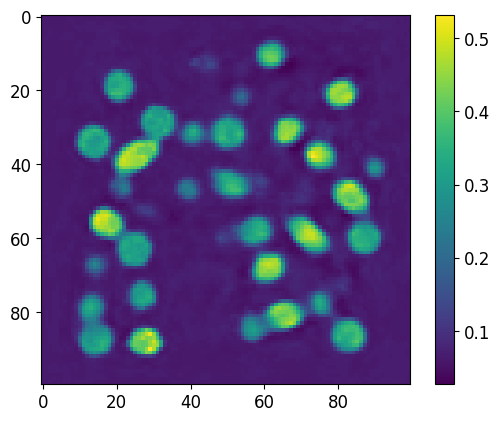

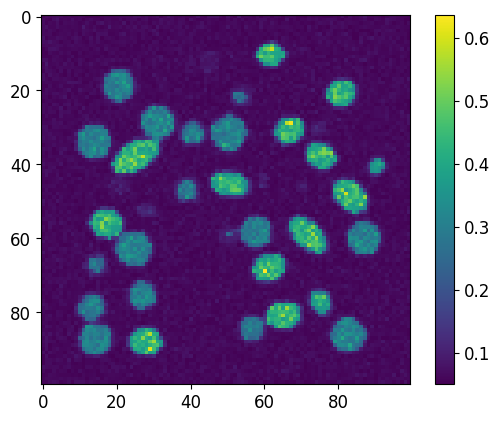

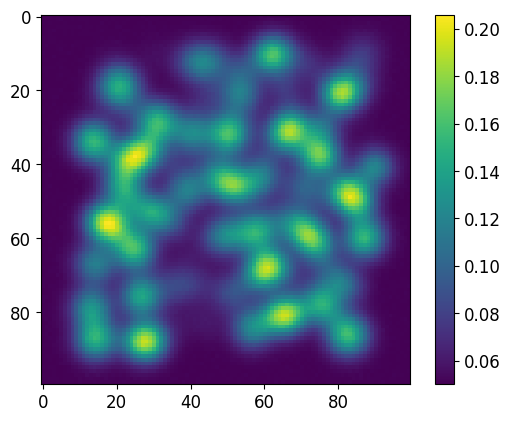

In [44]:
plt.imshow(m.numpy()[0, 0,:,:,scale//2-15])
plt.colorbar()
plt.show()

plt.imshow(high_map[0,:,:,scale//2-15])
plt.colorbar()
plt.show()


plt.imshow(low_map[0,:,:,scale//2-15])
plt.colorbar()
plt.show()